In [1]:
#math library for writing sq.rt
import math

In [2]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [3]:
#taking the coeff.s of the Hamiltonian from Mathematica file OneDrive-清華大學/Chi-Kwong Li/TSP/Codes/mathematica/TSL/TSL_newP_5c_withR.nb
#Also see the overleaf file for reference : https://www.overleaf.com/project/6524d9a57849dc8791655795
g = 20
d = 10

l00 = d
l01 =  math.sqrt(2)
l02 =  math.sqrt(10)
l03 = 3
l10 =  math.sqrt(2)
l11 = d
l12 = 2
l13 = math.sqrt(5)
l20 = math.sqrt(10)
l21 = 2
l22 = d
l23 = 1
l30 = 3
l31 = math.sqrt(5)
l32 = 1
l33 = d

d11 = 7 + (math.sqrt(5)/2)
d12 = -3 - (math.sqrt(5)/2)
d13 = -4 + (math.sqrt(5)/2)
d14 = 6 - (math.sqrt(5)/2)

d21 = d11
d22 = d12
d23 = d13
d24 = d14

c1 = 26 + (1/math.sqrt(2)) + math.sqrt(5/2)
c2 = -5 + math.sqrt(5/2)
c3 = -5 + (1/math.sqrt(2))
c4 = 4
c5 = -5 + math.sqrt(5/2)
c6 = 4 - (1/math.sqrt(2)) + math.sqrt(5/2)
c7 = -4
c8 = 5 - (1/math.sqrt(2))
c9 = -5 + (1/math.sqrt(2))
c10 = -4
c11 = 4 + (1/math.sqrt(2)) -  math.sqrt(5/2)
c12 = 5 -  math.sqrt(5/2)
c13 = 4
c14 = 5 -  (1/math.sqrt(2))
c15 = 5 -  math.sqrt(5/2)
c16 = 6 - (1/math.sqrt(2)) - math.sqrt(5/2)

In [4]:
# Constructing the Hamiltonian with local Paulis and their coeff.s
#The Hamiltonian (H1) consists of 5 terms, D1, C1, C2, D2 and Penalty (P).
D1 = SparsePauliOp.from_sparse_list([("", [], d11/2), ("Z", [4], d12/2), ("Z", [5], d13/2), ("ZZ", [4,5], d14/2)], num_qubits=6)

In [5]:
C1 = SparsePauliOp.from_sparse_list([("", [], c1/4), ("Z", [2], c2/4), ("Z", [3], c3/4), ("ZZ", [2,3], c4/4), ("Z", [4], c5/4), ("ZZ", [2,4], c6/4), ("ZZ", [3,4], c7/4), ("ZZZ", [2,3,4], c8/4), ("Z", [5], c9/4), ("ZZ", [2,5], c10/4), ("ZZ", [3,5], c11/4), ("ZZZ", [2,3,5], c12/4), ("ZZ", [4,5], c13/4), ("ZZZ", [2,4,5], c14/4), ("ZZZ", [3,4,5], c15/4), ("ZZZZ", [2,3,4,5], c16/4)],  num_qubits=6)

In [6]:
C2 = SparsePauliOp.from_sparse_list([("", [], c1/4), ("Z", [0], c2/4), ("Z", [1], c3/4), ("ZZ", [0,1], c4/4), ("Z", [2], c5/4), ("ZZ", [0,2], c6/4), ("ZZ", [1,2], c7/4), ("ZZZ", [0,1,2], c8/4), ("Z", [3], c9/4), ("ZZ", [0,3], c10/4), ("ZZ", [1,3], c11/4), ("ZZZ", [0,1,3], c12/4), ("ZZ", [2,3], c13/4), ("ZZZ", [0,2,3], c14/4), ("ZZZ", [1,2,3], c15/4), ("ZZZZ", [0,1,2,3], c16/4)],  num_qubits=6)

In [7]:
D2 = SparsePauliOp.from_sparse_list([("", [], d21/2), ("Z", [0], d22/2), ("Z", [1], d23/2), ("ZZ", [0,1], d24/2)], num_qubits=6)

In [8]:
P = SparsePauliOp.from_sparse_list([("", [], g/4), ("ZZ", [0,4], g/4), ("ZZ", [1,5], g/4), ("ZZZZ", [0,1,4,5], g/4)],  num_qubits=6)

In [9]:
#Hamiltonian 
cost_hamiltonian = D1 + C1 + C2 + D2 + P

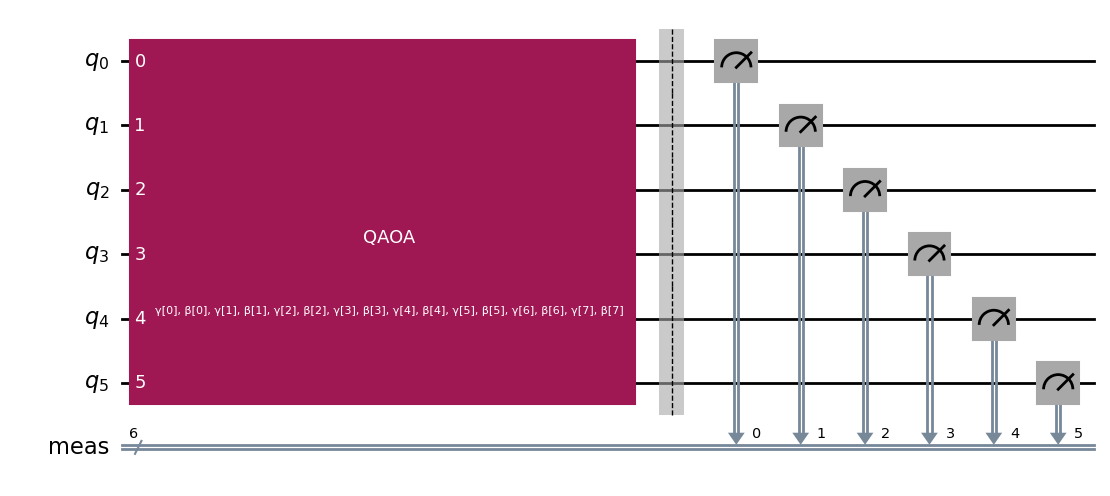

In [10]:
from qiskit.circuit.library import QAOAAnsatz
reps = 8
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=reps)
circuit.measure_all()

circuit.draw('mpl')

In [11]:
circuit.num_parameters

16

In [12]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
#AerSimulator
from qiskit_aer import AerSimulator

service = QiskitRuntimeService(name='ananduNTHU')
#backend = service.least_busy(min_num_qubits=127)
backend = AerSimulator()

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=1,
                                    backend=backend)

candidate_circuit = pm.run(circuit)
#candidate_circuit.draw('mpl', fold=False, idle_wires=False)

In [13]:
def create_init_params(reps, gamma=np.pi, beta=np.pi/2):
    """
    Create initialization parameters for quantum circuit.
    
    Args:
        reps (int): Number of repetitions
        gamma (float): Initial gamma value (default: π)
        beta (float): Initial beta value (default: π/2)
    
    Returns:
        list: List of alternating gamma and beta values
    """
    return [gamma, beta] * reps
init_params = create_init_params(reps)

In [14]:
print(len(init_params))

16


In [15]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [16]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(res)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 26.02567957208904
       x: [ 3.139e+00  1.569e+00 ...  3.142e+00  2.556e+00]
    nfev: 77
   maxcv: 0.0


The optimizer was able to reduce the cost and find better parameters for the circuit.


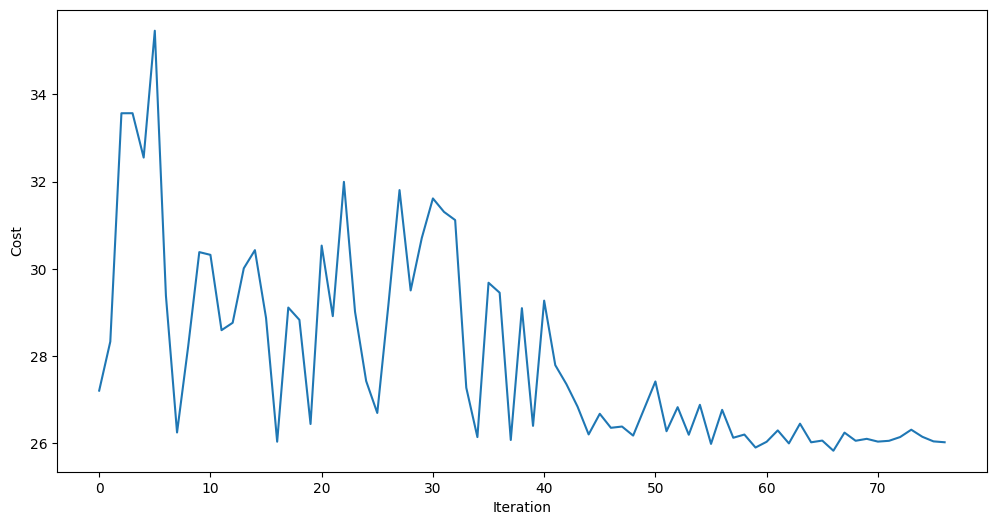

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [18]:
optimized_circuit = candidate_circuit.assign_parameters(res.x)
#optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [19]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
#sampler.options.dynamical_decoupling.enable = True
#sampler.options.dynamical_decoupling.sequence_type = "XY4"
#sampler.options.twirling.enable_gates = True
#sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
#print(final_distribution_int)

In [20]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, cost_hamiltonian.num_qubits)

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 0, 0, 1, 1, 0]


In [21]:
# Sort the dictionary items by values in descending order
sorted_items = sorted(counts_bin.items(), key=lambda x: x[1], reverse=True)
# Display the sorted key-value pairs
for key, value in sorted_items:
    print(f'{key}: {value}')

100110: 776
101110: 767
000100: 604
101000: 513
001010: 500
010001: 388
001110: 354
100000: 354
000001: 353
101100: 333
000010: 328
010000: 306
011001: 282
010101: 271
001100: 238
010010: 205
100001: 197
111000: 196
100010: 173
001011: 155
011101: 134
101101: 130
011011: 125
011110: 124
111001: 117
001001: 114
011000: 111
101111: 108
111110: 103
111101: 102
110001: 100
110011: 98
000110: 95
000000: 94
101011: 90
010011: 89
100100: 88
011111: 81
101010: 79
010110: 79
111010: 67
100101: 67
110110: 65
100111: 56
110010: 46
110111: 45
110101: 32
100011: 32
010111: 30
001101: 26
110000: 25
111111: 24
000111: 24
001000: 23
110100: 21
011100: 21
111011: 19
000011: 12
101001: 3
011010: 3
111100: 2
000101: 2
001111: 1
